In [ ]:
import math
import brian2 as b2
from brian2 import * 
from brian2tools import *
from brian2 import collect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import neurodynex3 as nd3
from functions_spectrum import *
from neurodynex3.leaky_integrate_and_fire import LIF
from neurodynex3.tools import input_factory, plot_tools
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import random
%matplotlib inline
from neurodynex3.adex_model import AdEx
from neurodynex3.tools import plot_tools, spike_tools
from neurodynex3.tools import plot_tools, input_factory
from brian2 import NeuronGroup, Synapses, PoissonInput, PoissonGroup, network_operation
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
import tqdm
import pickle
import logging
logging.getLogger(b2.__name__).setLevel(logging.ERROR)
logging.getLogger(nd3.__name__).setLevel(logging.ERROR)

In [9]:
rates_input_const = [4500]*4000 + [6500]*1000

In [ ]:
start_scope()
C_E = 0.25 *nF
C_I = 0.2 *nF
N_e = 4000
N_i = 1000
gL_E = 25 * nS
gL_I = 20 * nS

eL_E = -65.0 * mV
eL_I = -67.0 * mV

# refractory
refractory_E = 1.3 * ms
refractory_I = 1.3 * ms

# thresholds and exponential behavior
deltaT = 3.48 * mV
VT = -59.9 * mV
V_thr = -30 * mV
V_r = -68.0 * mV

# synaptic reversal potentials 
esynE = 0.0 * mV
esynI = -75.0 * mV  

# rise times
rise_AMPA = 0.5 * ms
rise_GABA = 0.5 * ms

# decay times
decay_AMPA = 2.0 * ms
decay_GABA = 5.0 * ms

# conductances 
gsynE_E = 4.5 * 1.3 * nS
gsynI_E = 6 * 8.75 * nS
gsynE_I = 2.3 * 0.93 * nS
gsynI_I = 3.3 * 6.2 * nS

# latencies
latency_AMPA = 1.5 *ms
latency_GABA = 0.5 *ms

# psx - postsynaptic constant x - added upon presyn. spike
psx_AMPA = 1.0
psx_GABA = 1.0
psx_AMPA_ext = 1.5

alpha = 1.0 / ms

#STDP
dApre = -0.2
dApost = 0.2
taupre = 20 *ms 
taupost = 20 *ms 

In [ ]:
# from attractors_and_oscillation/differential_equations/eif_equations.py (https://github.com/bnra/attractors_and_oscillation)

"""
Equations for the exponential integrate-and-fire neuron with AMPA and GABA type synaptic input based on

- Nicolas Fourcaud-Trocmé, David Hansel, Carl Van Vreeswijk, and Nicolas Brunel. How spike generation mechanisms determine the neuronal response to fluctuating inputs. Journal of neuroscience, 23(37):11628–11640, 2003.

- Nicolas Brunel and Xiao-Jing Wang. What determines the frequency of fast network oscillations with irregular neural discharges? i. synaptic dynamics and excitation-inhibition balance. Journal of neurophysiology, 90(1):415–430, 2003.

- AAshqar :ref: https://github.com/AAshqar/GammaCoupling/blob/develop/NeuronsSpecs/NeuronEqs_DFsepI.py
"""

eq_eif = """
    dV/dt = (-gL*(V-eL) + gL*deltaT*exp((V-VT)/deltaT) - IsynE - IsynI - IsynE_ext + Iext) / C : volt
    IsynE_ext = gsynE * (V - esynE) * synE_ext : amp
    IsynE = gsynE * (V - esynE) * synE : amp
    IsynI = gsynI * (V - esynI) * synI : amp
    dsynE_ext/dt = alpha * x_AMPA_ext - synE_ext/decay_AMPA : 1
    dsynE/dt = alpha * x_AMPA - synE/decay_AMPA : 1
    dsynI/dt = alpha * x_GABA - synI/decay_GABA : 1
    dx_AMPA_ext/dt = -x_AMPA_ext/rise_AMPA : 1
    dx_GABA/dt = -x_GABA/rise_GABA : 1
    dx_AMPA/dt = -x_AMPA/rise_AMPA : 1
    Iext : amp
    """

eq_eif_E = (
    eq_eif.replace("gsynE", "gsynE_E")
    .replace("gsynI", "gsynI_E")
    .replace("C", "C_E")
    .replace("gL", "gL_E")
    .replace("eL", "eL_E")
)

eq_eif_I = (
    eq_eif.replace("gsynE", "gsynE_I")
    .replace("gsynI", "gsynI_I")
    .replace("C", "C_I")
    .replace("gL", "gL_I")
    .replace("eL", "eL_I")
)


pre_eif_E = "x_AMPA += psx_AMPA"
pre_eif_I = "x_GABA += psx_GABA"
pre_eif_Pois = "x_AMPA_ext += psx_AMPA_ext"

Syn_model = '''
            w: 1
            w_max : 1
            plastic : 1 (shared)
            notplastic : 1 (shared)
            dApre/dt = - (Apre / taupre) *int(plastic) : 1 (event-driven)
            dApost/dt = - (Apost / taupost) *int(plastic): 1 (event-driven)

        '''

Pre_eq = '''
            x_AMPA = x_AMPA + psx_AMPA*int(notplastic) + w*int(plastic)
            Apre = Apre + dApre*int(plastic)           
            w = clip(w + Apost, 0, w_max)                                        
        ''' 

Post_eq = '''
            Apost = Apost + dApost*int(plastic)    
            w = clip(w + Apre, 0, w_max)                                       
        ''' 

Syn_model_I = '''
            w: 1
            w_max : 1
            plastic : boolean (shared)
            notplastic : boolean (shared)
            dApre/dt = - (Apre / taupre) *int(plastic) : 1 (event-driven)
            dApost/dt = - (Apost / taupost) *int(plastic): 1 (event-driven)
        '''

Pre_eq_I = '''
            x_GABA = x_GABA + w*int(plastic) + psx_GABA*int(notplastic)    
            Apre = Apre + dApre*int(plastic)            
            w = clip(w + Apost, 0, w_max)                                        
        ''' 

Post_eq_I = '''
            Apost = Apost + dApost*int(plastic)    
            w = clip(w + Apre, 0, w_max) 
        '''

In [ ]:
# setting neuros 
defaultclock.dt = 0.1*msecond                       # timestep

E = NeuronGroup(N_e, eq_eif_E, threshold="V>V_thr", reset="V = V_r", refractory=refractory_E, method="rk2")
I = NeuronGroup(N_i, eq_eif_I, threshold="V>V_thr", reset="V = V_r", refractory=refractory_I, method="rk2")

E.V = eL_E
I.V = eL_I

P = PoissonGroup(5000, rates=rates_input_const*Hz)

# creating synapses

S_E_E = Synapses(E, E, model=Syn_model, on_pre=Pre_eq, on_post=Post_eq, delay=latency_AMPA)
S_P_E = Synapses(P[0:4000], E, on_pre=pre_eif_Pois, delay=latency_AMPA)
S_P_I = Synapses(P[4000:5000], I, on_pre=pre_eif_Pois, delay=latency_AMPA)
S_P_E.connect(j='i')
S_P_I.connect(j='i')

S_E_I = Synapses(E, I, on_pre=pre_eif_E, delay=latency_AMPA)
S_I_E = Synapses(I, E, on_pre=pre_eif_I, delay=latency_GABA)
S_I_I = Synapses(I, I, on_pre=pre_eif_I, delay=latency_GABA)
S_E_E.connect(p = 0.01)
S_E_I.connect(p = 0.1)
S_I_E.connect(p = 0.1)
S_I_I.connect(p = 0.1)

S_E_E.w = 'rand() * 1'
S_E_E.w_max = 1

In [ ]:
state_monitor_V_E = StateMonitor(E, 'V', record=True)
state_monitor_V_I = StateMonitor(I, 'V', record=True)
spikes_E = SpikeMonitor(E)
spikes_I = SpikeMonitor(I)
spikes_input = SpikeMonitor(P)
rate_E = PopulationRateMonitor(E)
rate_I = PopulationRateMonitor(I)
state_monitor_Isyn = StateMonitor(I, 'IsynI', record=True)
state_monitor_Isyn_E = StateMonitor(E, 'IsynE', record=True)

W_evolution_E_E = StateMonitor(S_E_E, 'w', record = True, dt=100*ms)

In [ ]:
S_E_E.plastic = 0
S_E_E.notplastic = 1
state_monitor_V_E.active = False
state_monitor_V_I.active = False
spikes_E.active = False
spikes_I.active = False
spikes_input.active = False
rate_E.active = False
rate_I.active = False
state_monitor_Isyn.active = False
state_monitor_Isyn_E.active = False

W_evolution_E_E.active = False
run(200*msecond, report='text')

S_E_E.plastic = 0
S_E_E.notplastic = 1
state_monitor_V_E.active = False
state_monitor_V_I.active = False
spikes_E.active = True
spikes_I.active = True
spikes_input.active = False
rate_E.active = True
rate_I.active = True
state_monitor_Isyn.active = False
state_monitor_Isyn_E.active = False

W_evolution_E_E.active = False
run(2000*msecond, report='text')

state_monitor_V_E.active = True
state_monitor_V_I.active = True
spikes_E.active = True
spikes_I.active = True
spikes_input.active = True
rate_E.active = True
rate_I.active = True
state_monitor_Isyn.active = True
state_monitor_Isyn_E.active = True
W_evolution_E_E.active = True

run(500*msecond, report='text')

Starting simulation at t=0. s for a duration of 200. ms
200. ms (100%) simulated in 1s
Starting simulation at t=200. ms for a duration of 2. s
1.3383 s (66%) simulated in 10s, estimated 5s remaining.
2. s (100%) simulated in 14s
Starting simulation at t=2.2 s for a duration of 0.5 s
0.5 s (100%) simulated in 5s


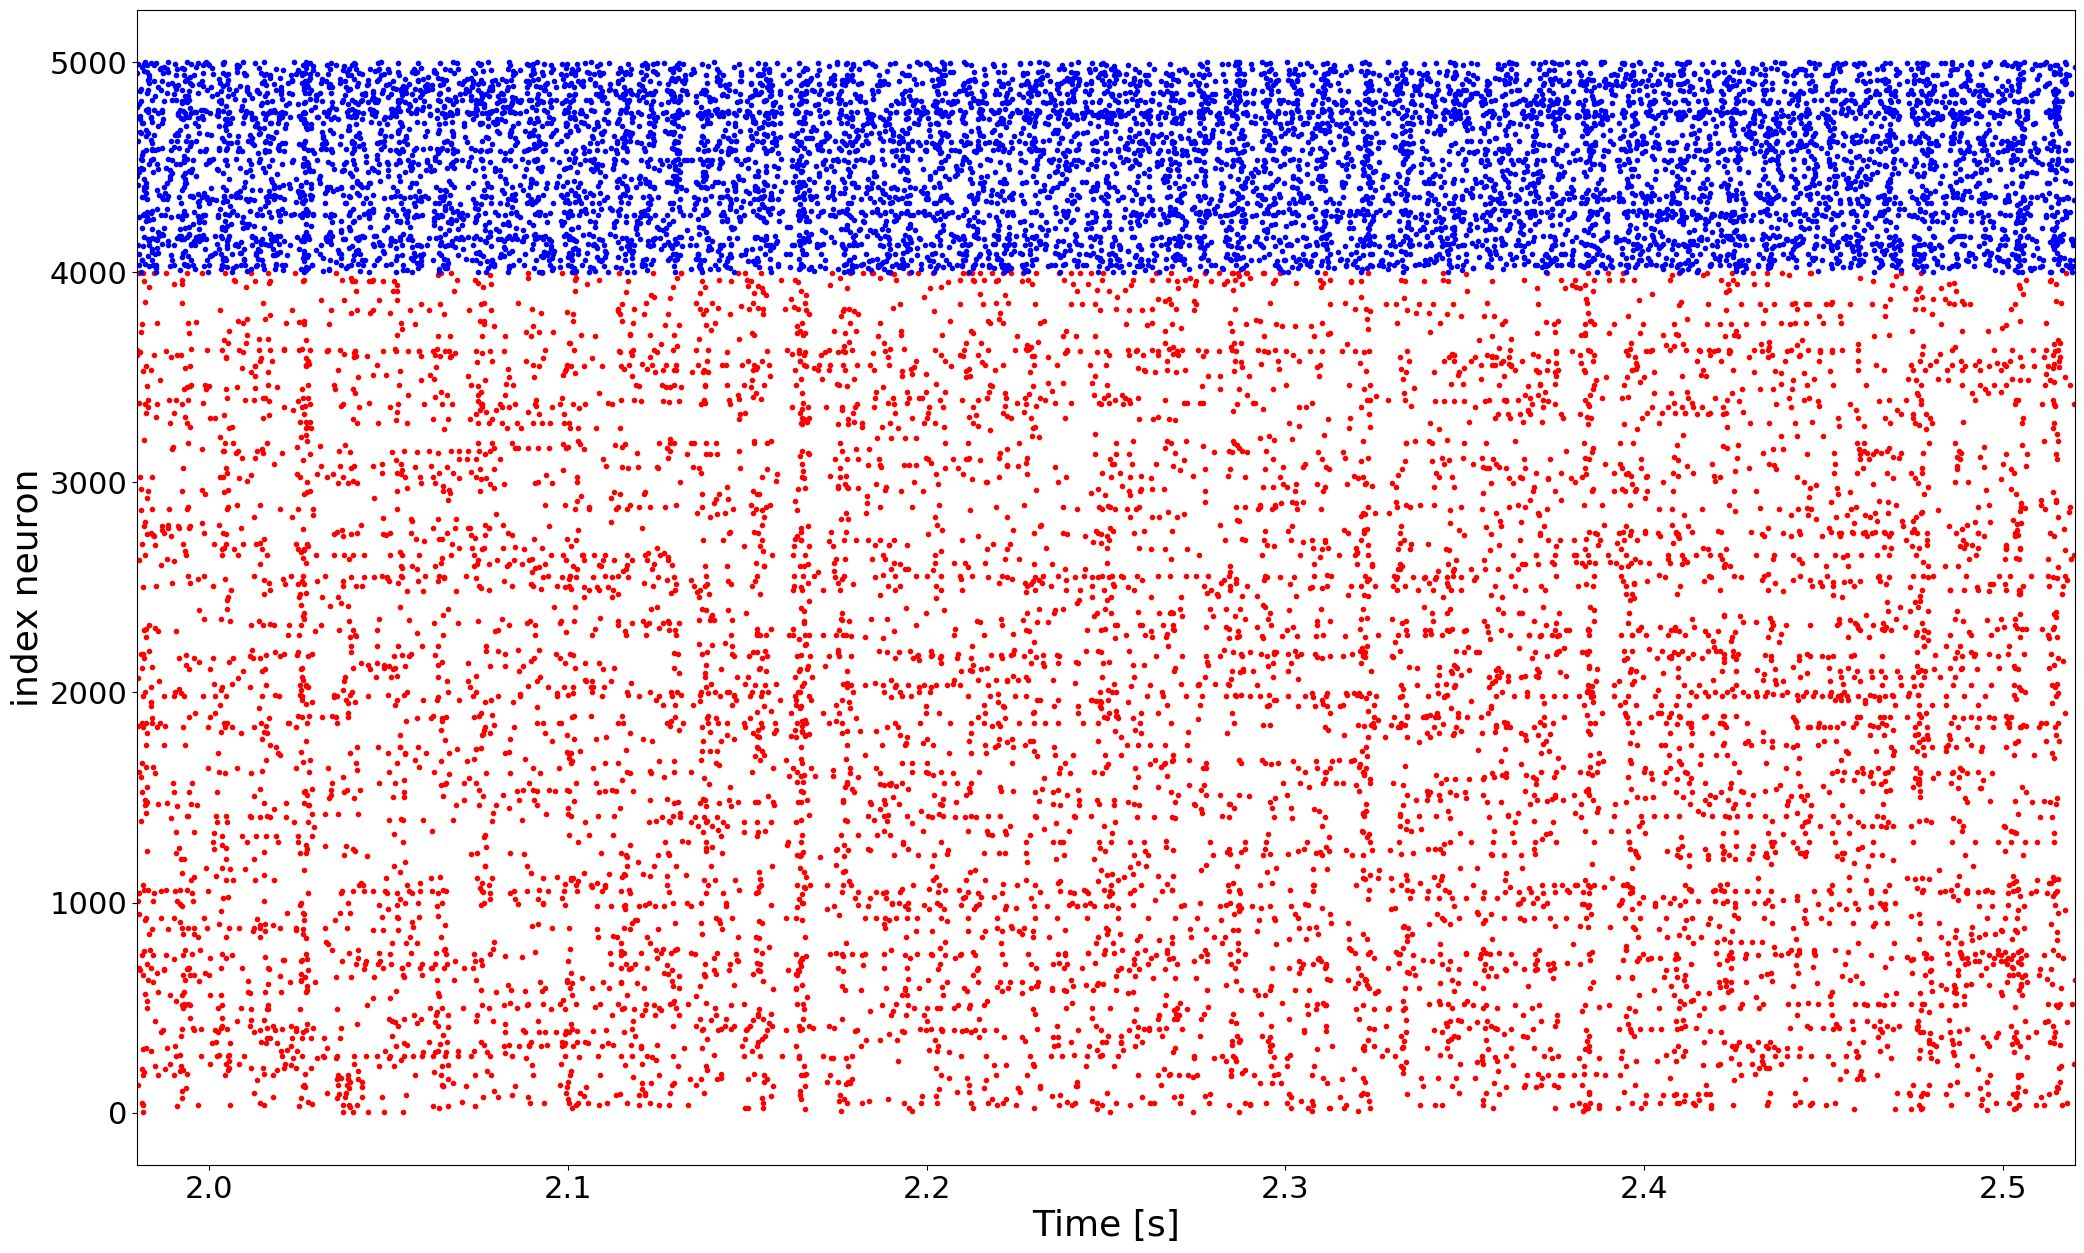

In [8]:
fig = figure(figsize=(25, 15))
plt.plot(spikes_E.t, spikes_E.i, '.', color = 'r')

# plt.plot(spikes_I.t, [spikes_I.i[kk] + 400 for kk in range(0,100)],'.', color ='b')
plt.plot(spikes_I.t, spikes_I.i + 4000,'.', color ='b')
xlabel('Time [s]', size = 26)
ylabel('index neuron', size = 26)
xlim(1.98, 2.52)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

In [6]:
E_self = []
for i,j in zip(S_E_E.i, S_E_E.j):
    if i == j:
        # print(i,j)
        E_self.append(i)

In [8]:
I_self = []
for i,j in zip(S_I_I.i, S_I_I.j):
    if i == j:
        I_self.append(i)

In [12]:
E_I_self = []
I_E_self = []
for i,j in zip(S_I_E.i[:159618], S_I_E.j[:159618]):
    if i in I_self and j in E_self and (j,i) in zip(S_E_I.i[:159618], S_E_I.j[:159618]):
        print(i,j)
        # print('Num of spikes neuron %s E: {}'.format(spikes_E.count[j]) % j)
        # print('Num of spikes neuron %s I: {}'.format(spikes_I.count[i]) % i)
        I_E_self.append(i)
        E_I_self.append(j)

8 519
8 716
9 752
25 501
53 677
83 752
86 1158
132 1554
174 677
201 664
214 1554
326 1165
397 288
397 1165


In [ ]:
import collections
subgroup = E
conn_dict = collections.defaultdict(list)
for i, j in zip(S_E_E.i[subgroup, subgroup], S_E_E.j[subgroup, subgroup]):
     conn_dict[i].append(j)
 
print(dict(conn_dict))
S_E_E.i[0]

{0: [8, 51, 78, 102, 154, 198, 341, 600, 751, 785, 833, 1052, 1077, 1116, 1174, 1396, 1502, 1528, 1726, 1765, 1778, 1821, 1837, 1848, 1993, 2072, 2402, 2464, 2620, 2673, 3247, 3258, 3274, 3310, 3361, 3571, 3650, 3718, 3818, 3879], 1: [161, 380, 509, 790, 890, 1340, 1356, 1428, 1909, 1929, 1971, 2132, 2172, 2227, 2347, 2382, 2458, 2656, 2668, 2849, 2868, 3074, 3103, 3134, 3258, 3360, 3438, 3522, 3562, 3612, 3660, 3683, 3991], 2: [202, 221, 246, 355, 386, 398, 448, 513, 556, 657, 690, 776, 828, 855, 1076, 1105, 1302, 1339, 1537, 1652, 1655, 1676, 1765, 1963, 2399, 2482, 2551, 2736, 2753, 3042, 3104, 3133, 3143, 3400, 3565, 3822, 3883, 3884, 3892], 3: [8, 140, 456, 611, 842, 854, 1031, 1094, 1111, 1359, 1385, 1561, 1574, 1672, 1706, 1841, 2010, 2073, 2245, 2276, 2296, 2305, 2309, 2334, 2408, 2437, 2449, 2580, 2608, 2688, 2741, 2784, 3037, 3189, 3529, 3539, 3596, 3920, 3951], 4: [39, 122, 155, 224, 316, 638, 677, 785, 822, 845, 1066, 1089, 1096, 1153, 1174, 1217, 1331, 1382, 1445, 1540, 17

0

In [ ]:
spikes_I_data_before = spikes_I.get_states(['t', 'i'], units=False, format='pandas')
spikes_I_data_before.to_csv('spikes_I_EE_before.csv', index=False)

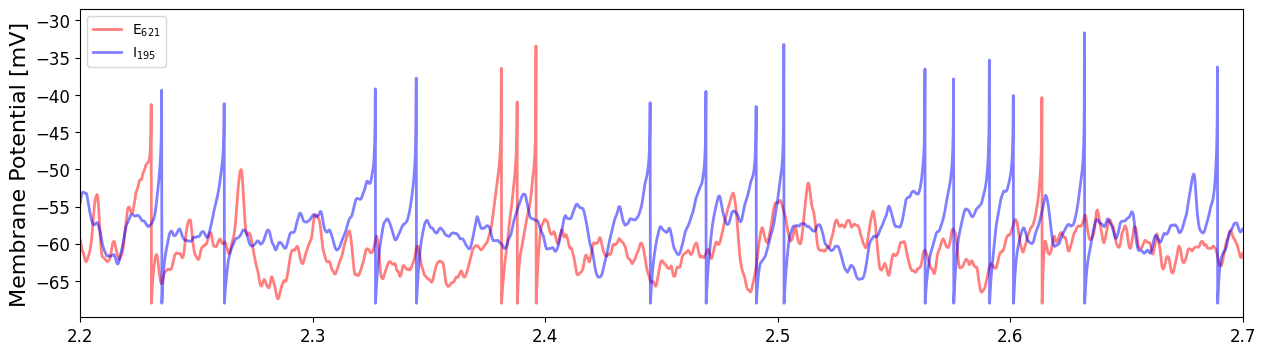

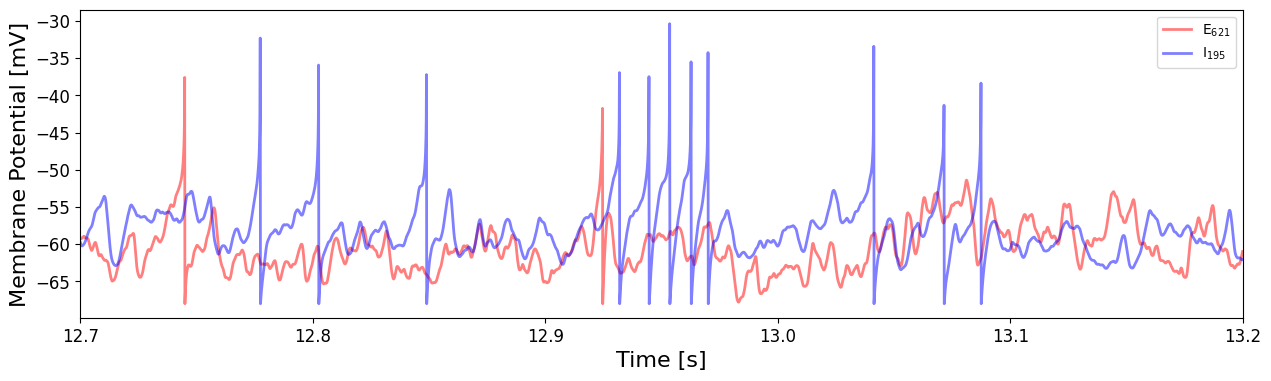

In [55]:
fig = figure(figsize=(15, 4))
for kk in [621]:
    plt.plot(state_monitor_V_E.t, state_monitor_V_E.V[kk] / mV, '-', lw=2, label='E$_{%s}$' % kk, color = 'r', alpha = 0.5)
    # print('Num of spikes neuron %s E: {}'.format(spikes_E.count[kk]) % kk)
    plt.legend()
for kk in [195]:
    plt.plot(state_monitor_V_I.t, state_monitor_V_I.V[kk] / mV, '-', lw=2, label='I$_{%s}$' % kk, color ='b', alpha = 0.5)
    # print('Num of spikes neuron %s I: {}'.format(spikes_I.count[kk]) % kk)
    plt.legend()
xlim(2.2,2.7)
ylabel('Membrane Potential [mV]', size = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
fig = figure(figsize=(15, 4))
for kk in [621]:
    plt.plot(state_monitor_V_E.t, state_monitor_V_E.V[kk] / mV, '-', lw=2, label='E$_{%s}$' % kk, color = 'r', alpha = 0.5)
    # print('Num of spikes neuron %s E: {}'.format(spikes_E.count[kk]) % kk)
    plt.legend()
for kk in [195]:
    plt.plot(state_monitor_V_I.t, state_monitor_V_I.V[kk] / mV, '-', lw=2, label='I$_{%s}$' % kk, color ='b', alpha = 0.5)
    # print('Num of spikes neuron %s I: {}'.format(spikes_I.count[kk]) % kk)
    plt.legend()
xlim(12.7,13.2)
xlabel('Time [s]', size = 16)
ylabel('Membrane Potential [mV]', size = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [10]:
max(rate_E.rate)

30. * hertz

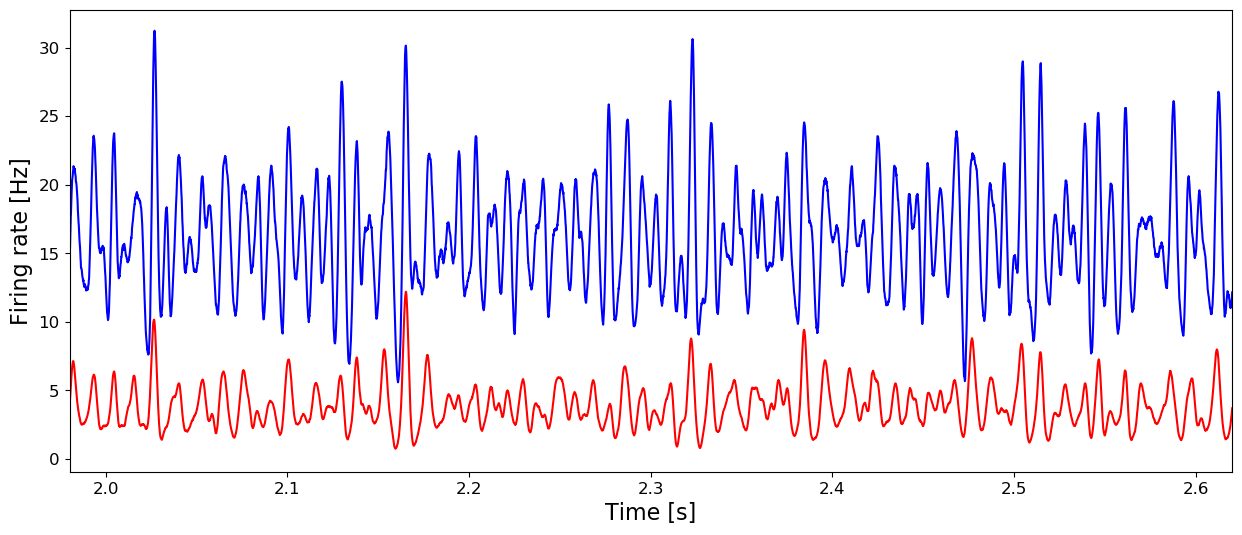

In [9]:
fig = figure(figsize=(15, 6))
smooth_width = 1*ms
plt.plot(rate_E.t, rate_E.smooth_rate(window='gaussian', width=1 *msecond), color = 'r')
plt.plot(rate_I.t, rate_I.smooth_rate(window='gaussian', width=1 *msecond), color = 'b')
# plt.plot(rate_E.t, rate_E.rate, color = 'r')
# plt.plot(rate_I.t, rate_I.rate, color = 'b')
xlabel('Time [s]', size = 16)
ylabel('Firing rate [Hz]', size = 16)
xlim(1.98, 2.62)
# ylim(-2,45)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [10]:
print('Mean firing rate I =', np.mean(rate_I.rate), 'Hz')
print('Mean firing rate E =', np.mean(rate_E.rate), 'Hz')

Mean firing rate I = 16.2076 Hz
Mean firing rate E = 3.8226 Hz


In [ ]:
# Specify the signal and simulation properties:
delta_t = 0.1 * ms
f_sampling = 1/0.1 * Hz
T_init = 200 * ms
k = 1
N_samples = 25000
T_signal = 2500 *ms
T_sim = k * T_signal + T_init
f_max = 1./(2. * delta_t)
delta_f = 1/(0.1*N_samples) * Hz
N_init = 0

1000 1.0
mean_firing_rate:16.3256
563
404


(<Figure size 640x480 with 1 Axes>, [563, 404])

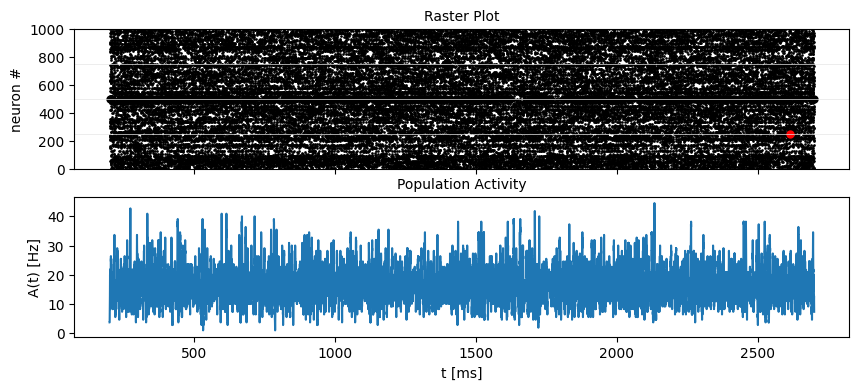

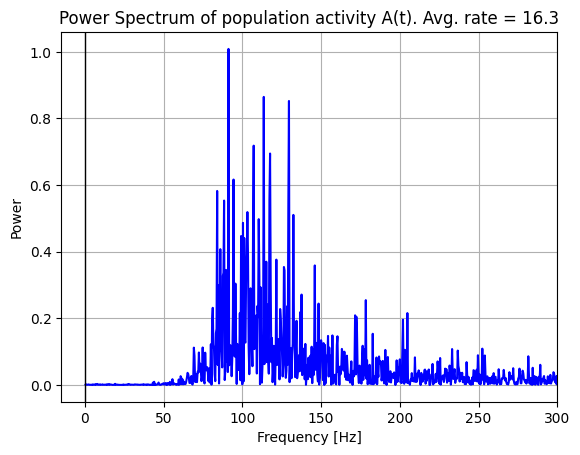

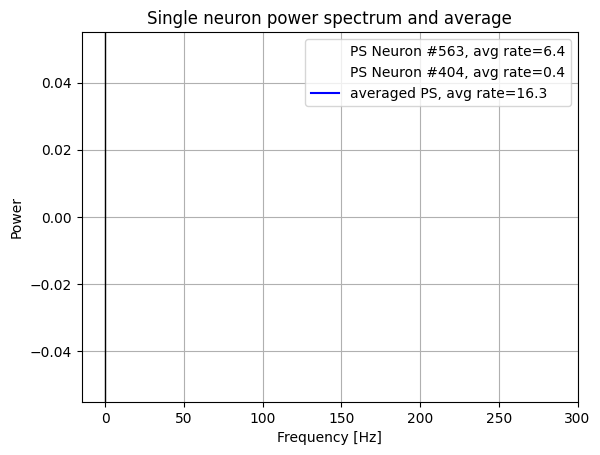

In [113]:
plot_tools.plot_network_activity(rate_I, spikes_I, t_min = 60 *ms, spike_train_idx_list=list(range(1000)))
pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_I, delta_f, 1, T_init)
plot_population_activity_power_spectrum(pop_freqs, pop_ps, 300 * Hz, average_population_rate)
freq, mean_ps, all_ps, mean_firing_rate, all_mean_firing_freqs = \
    get_averaged_single_neuron_power_spectrum(
        spikes_I, sampling_frequency=delta_f, window_t_min= T_init,
        window_t_max=T_sim, nr_neurons_average= 1000 )
plot_spike_train_power_spectrum(freq, mean_ps, all_ps, max_freq= 300 * Hz,
                                           mean_firing_freqs_per_neuron=all_mean_firing_freqs,
                                           nr_highlighted_neurons=2)

4000 2500.5
mean_firing_rate:0.0
654
3379
3345


(<Figure size 640x480 with 1 Axes>, [654, 3379, 3345])

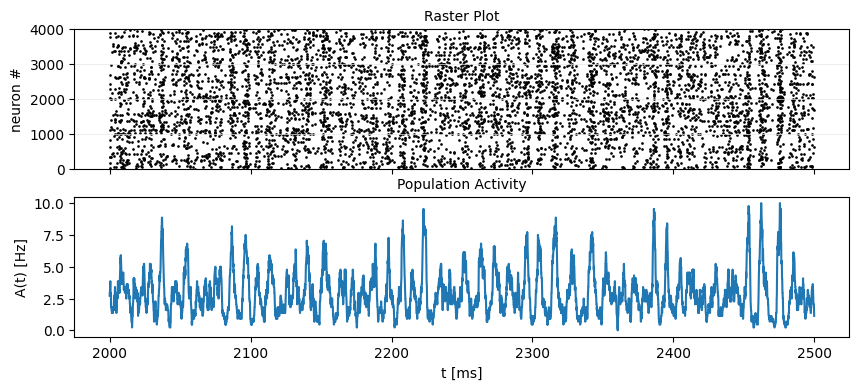

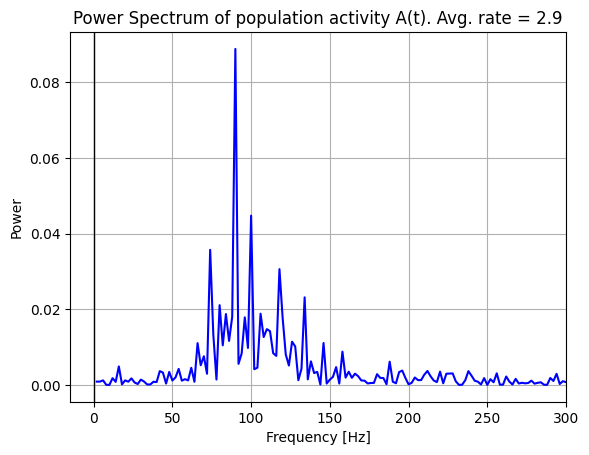

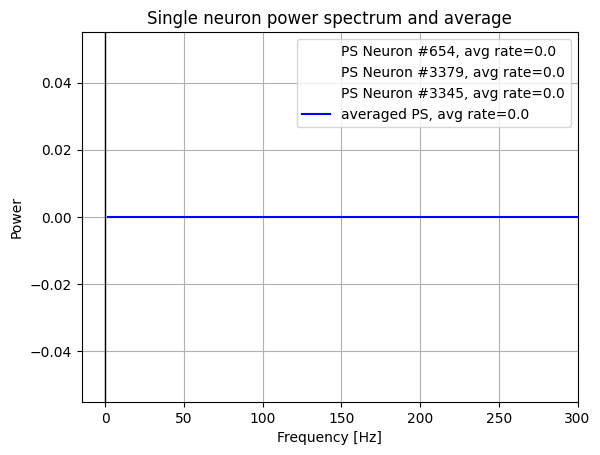

In [23]:
plot_tools.plot_network_activity(rate_E, spikes_E, t_min = 2000 *ms, spike_train_idx_list=list(range(4000)))
pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_E, delta_f, k, T_init)
plot_population_activity_power_spectrum(pop_freqs, pop_ps, 300 * Hz, average_population_rate)
freq, mean_ps, all_ps, mean_firing_rate, all_mean_firing_freqs = \
    get_averaged_single_neuron_power_spectrum(
        spikes_E, sampling_frequency=1./delta_t, window_t_min= T_init,
        window_t_max=T_sim, nr_neurons_average= 4000 )
plot_spike_train_power_spectrum(freq, mean_ps, all_ps, max_freq= 300 * Hz,
                                           mean_firing_freqs_per_neuron=all_mean_firing_freqs,
                                           nr_highlighted_neurons=3)

In [19]:
spikes_E_after = SpikeMonitor(E)
spikes_I_after = SpikeMonitor(I)
rate_E_after = PopulationRateMonitor(E)
rate_I_after = PopulationRateMonitor(I)

In [ ]:
S_E_E.plastic = 1
S_E_E.notplastic = 0
state_monitor_V_E.active = False
state_monitor_V_I.active = False
spikes_E.active = False
spikes_I.active = False
spikes_input.active = False
spikes_E_after.active = False
spikes_I_after.active = False
rate_E.active = False
rate_I.active = False
rate_E_after.active = False
rate_I_after.active = False
state_monitor_Isyn.active = False
state_monitor_Isyn_E.active = False
W_evolution_E_E.active = False
run(8000*msecond, report='text')

state_monitor_V_E.active = False
state_monitor_V_I.active = False
spikes_E.active = False
spikes_I.active = False
spikes_input.active = False
spikes_E_after.active = True
spikes_I_after.active = True
rate_E.active = False
rate_I.active = False
rate_E_after.active = True
rate_I_after.active = True
state_monitor_Isyn.active = False
state_monitor_Isyn_E.active = False
W_evolution_E_E.active = True
run(2000*msecond, report='text')


state_monitor_V_E.active = True
state_monitor_V_I.active = True
spikes_E_after.active = True
spikes_I_after.active = True
rate_E_after.active = True
rate_I_after.active = True
state_monitor_Isyn.active = True
state_monitor_Isyn_E.active = True
W_evolution_E_E.active = True
run(500*msecond, report='text')


Starting simulation at t=2.7 s for a duration of 8. s
1.7361 s (21%) simulated in 10s, estimated 36s remaining.
3.4703 s (43%) simulated in 20s, estimated 26s remaining.
5.1905 s (64%) simulated in 30s, estimated 16s remaining.
6.918 s (86%) simulated in 40s, estimated 6s remaining.
8. s (100%) simulated in 46s
Starting simulation at t=10.7 s for a duration of 2. s
1.5176 s (75%) simulated in 10s, estimated 3s remaining.
2. s (100%) simulated in 13s
Starting simulation at t=12.7 s for a duration of 0.5 s
0.5 s (100%) simulated in 4s


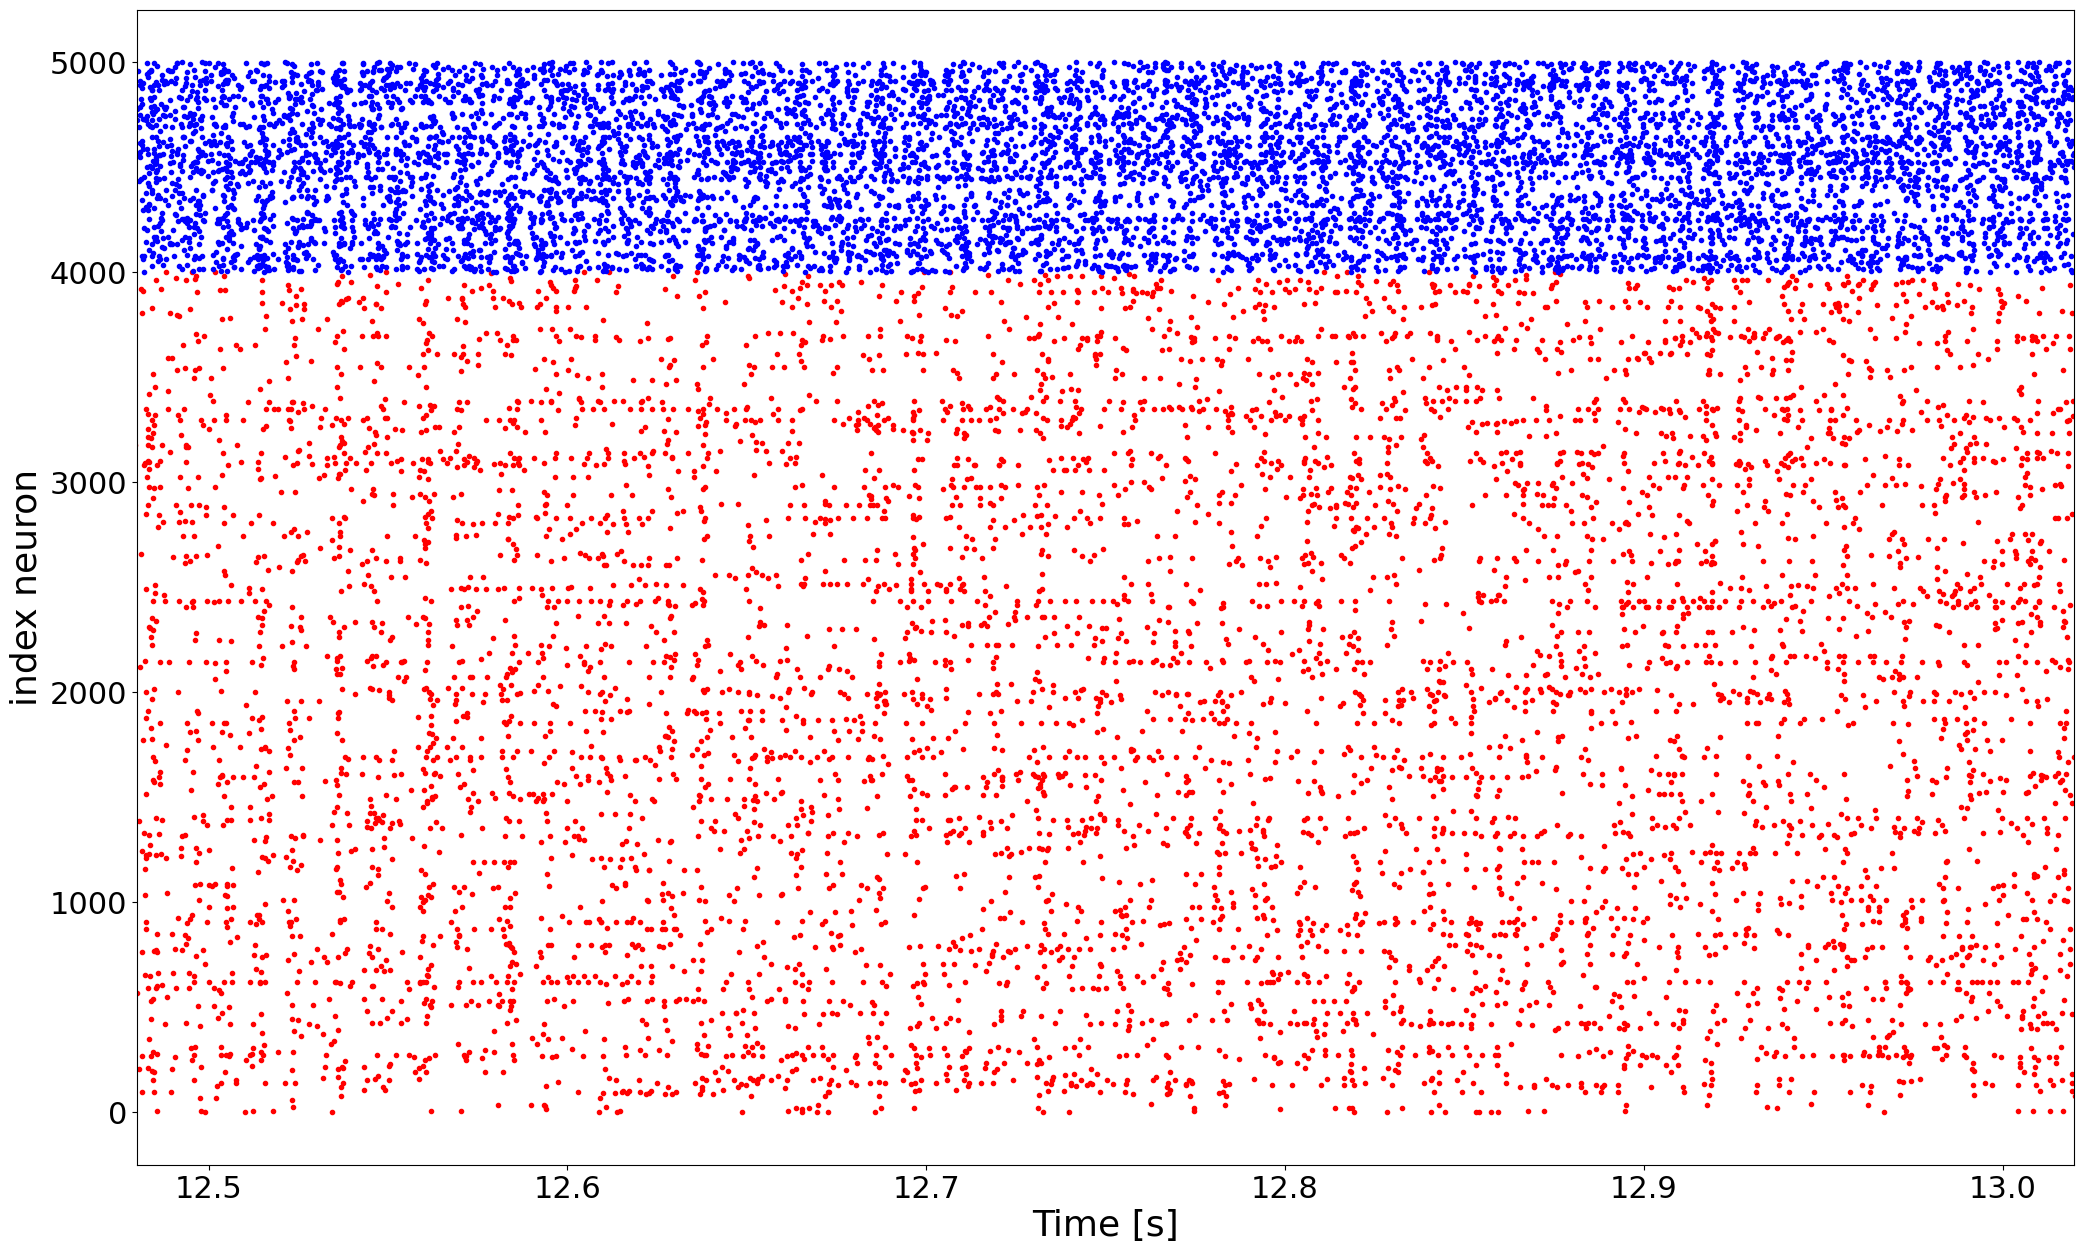

In [ ]:
fig = figure(figsize=(25, 15))
plt.plot(spikes_E_after.t, spikes_E_after.i, '.', color = 'r')
plt.plot(spikes_I_after.t, spikes_I_after.i + 4000,'.', color ='b')
xlabel('Time [s]', size = 26)
ylabel('index neuron', size = 26)
xlim(12.48, 13.02)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

Num of spikes neuron 2418 E: 0
Num of spikes neuron 206 I: 112


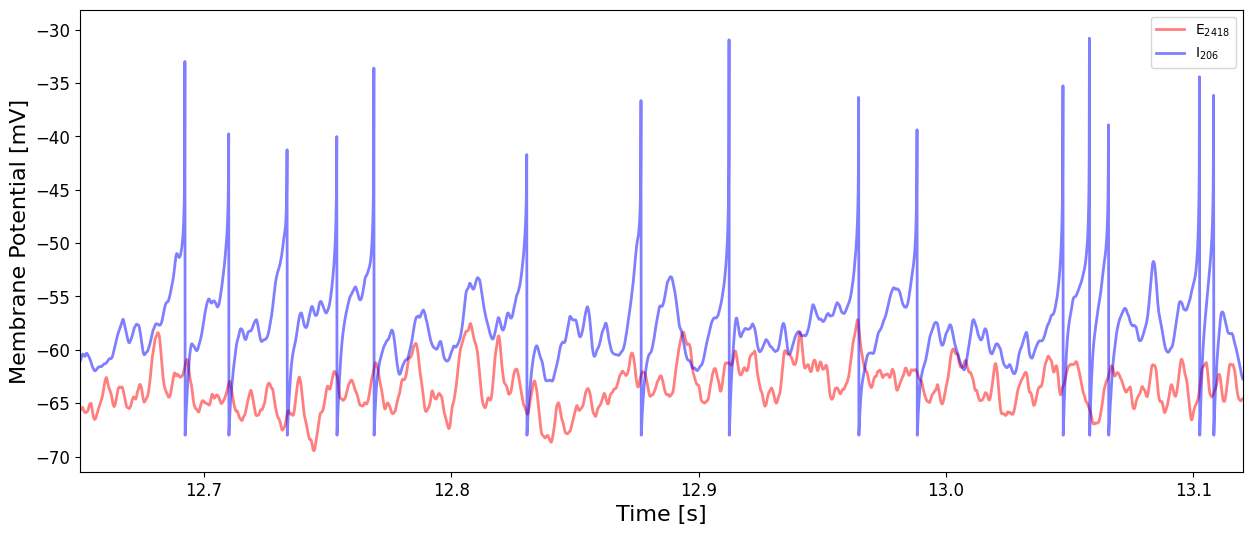

In [16]:
fig = figure(figsize=(15, 6))
for kk in [2418]:
    plt.plot(state_monitor_V_E.t, state_monitor_V_E.V[kk] / mV, '-', lw=2, label='E$_{%s}$' % kk, color = 'r', alpha = 0.5)
    print('Num of spikes neuron %s E: {}'.format(spikes_E.count[kk]) % kk)
    plt.legend()
for kk in [206]:
    plt.plot(state_monitor_V_I.t, state_monitor_V_I.V[kk] / mV, '-', lw=2, label='I$_{%s}$' % kk, color ='b', alpha = 0.5)
    print('Num of spikes neuron %s I: {}'.format(spikes_I.count[kk]) % kk)
    plt.legend()
xlim(12.65,13.12)
xlabel('Time [s]', size = 16)
ylabel('Membrane Potential [mV]', size = 16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

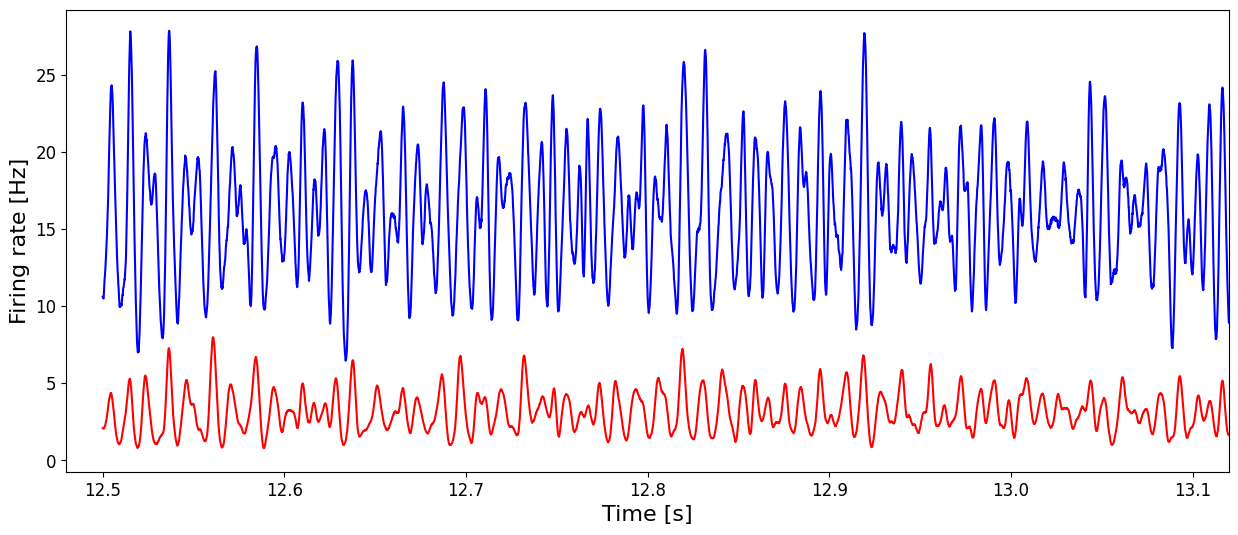

In [23]:
fig = figure(figsize=(15, 6))
smooth_width = 1*ms
plt.plot(rate_E_after.t[18000:], rate_E_after.smooth_rate(window='gaussian', width=1 *msecond)[18000:], color = 'r')
plt.plot(rate_I_after.t[18000:], rate_I_after.smooth_rate(window='gaussian', width=1 *msecond)[18000:], color = 'b')
# plt.plot(rate_E.t, rate_E.rate, color = 'r')
# plt.plot(rate_I.t, rate_I.rate, color = 'b')
xlabel('Time [s]', size = 16)
ylabel('Firing rate [Hz]', size = 16)
xlim(12.48, 13.12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [24]:
print('Mean firing rate =', np.mean(rate_I_after.rate), 'Hz')
print('Mean firing rate =', np.mean(rate_E_after.rate), 'Hz')

Mean firing rate = 16.2012 Hz
Mean firing rate = 3.2512 Hz


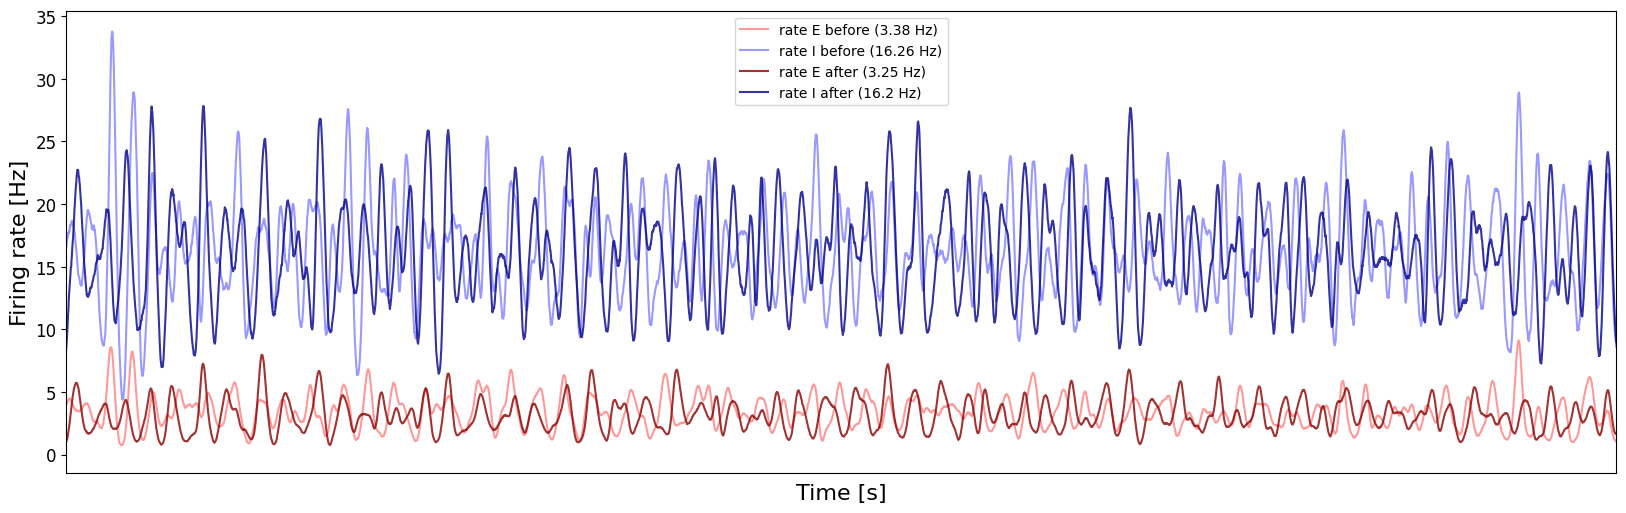

In [25]:
fig = figure(figsize=(20, 6))
smooth_width = 1*ms
plt.plot(rate_E.t, rate_E.smooth_rate(window='gaussian', width=1 *msecond), color = 'red', alpha = 0.4, label = 'rate E before (%s Hz)'  % np.round(np.mean(rate_E.rate),2))
plt.plot(rate_I.t, rate_I.smooth_rate(window='gaussian', width=1 *msecond), color = 'blue', alpha = 0.4, label = 'rate I before (%s Hz)'  % np.round(np.mean(rate_I.rate),2))
plt.plot(rate_E.t, rate_E_after.smooth_rate(window='gaussian', width=1 *msecond), color = 'darkred', alpha = 0.8, label = 'rate E after (%s Hz)'  % np.round(np.mean(rate_E_after.rate),2))
plt.plot(rate_I.t, rate_I_after.smooth_rate(window='gaussian', width=1 *msecond), color = 'darkblue', alpha = 0.8, label = 'rate I after (%s Hz)'  % np.round(np.mean(rate_I_after.rate),2))
plt.legend()
# plt.plot(rate_E.t, rate_E.rate, color = 'r')
# plt.plot(rate_I.t, rate_I.rate, color = 'b')
xlabel('Time [s]', size = 16)
ylabel('Firing rate [Hz]', size = 16)
xlim(1.98, 2.62)
# ylim(-2,45)
plt.xticks([], fontsize=12)
plt.yticks(fontsize=12)
plt.show()

1000 2500.5
mean_firing_rate:0.0
59
130


(<Figure size 640x480 with 1 Axes>, [59, 130])

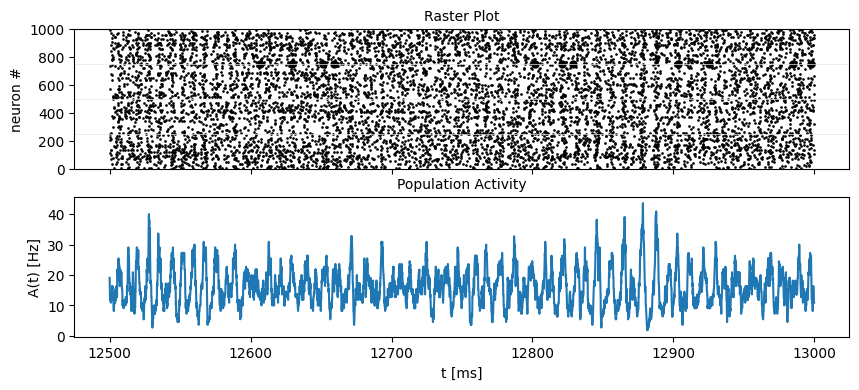

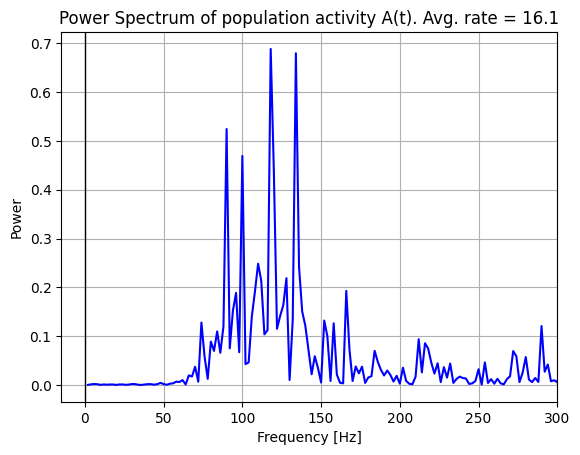

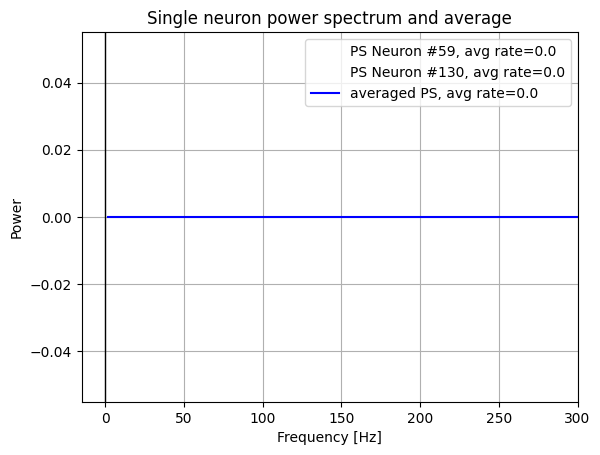

In [30]:
plot_tools.plot_network_activity(rate_I, spikes_I, t_min = 12500 *ms, spike_train_idx_list=list(range(1000)))
pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_I, delta_f, k, T_init)
plot_population_activity_power_spectrum(pop_freqs, pop_ps, 300 * Hz, average_population_rate)
freq, mean_ps, all_ps, mean_firing_rate, all_mean_firing_freqs = \
    get_averaged_single_neuron_power_spectrum(
        spikes_I, sampling_frequency=1./delta_t, window_t_min= T_init,
        window_t_max=T_sim, nr_neurons_average= 1000 )
plot_spike_train_power_spectrum(freq, mean_ps, all_ps, max_freq= 300 * Hz,
                                           mean_firing_freqs_per_neuron=all_mean_firing_freqs,
                                           nr_highlighted_neurons=2)

4000 2500.5
mean_firing_rate:0.0
713
2143
3124


(<Figure size 640x480 with 1 Axes>, [713, 2143, 3124])

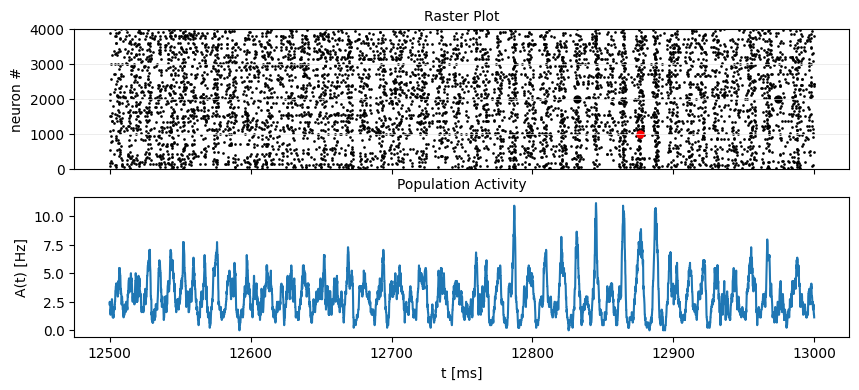

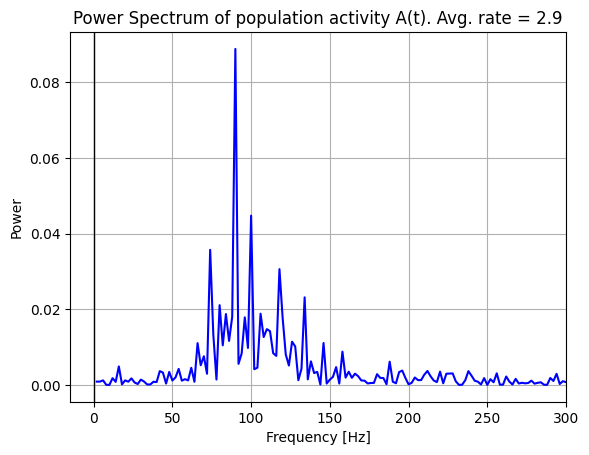

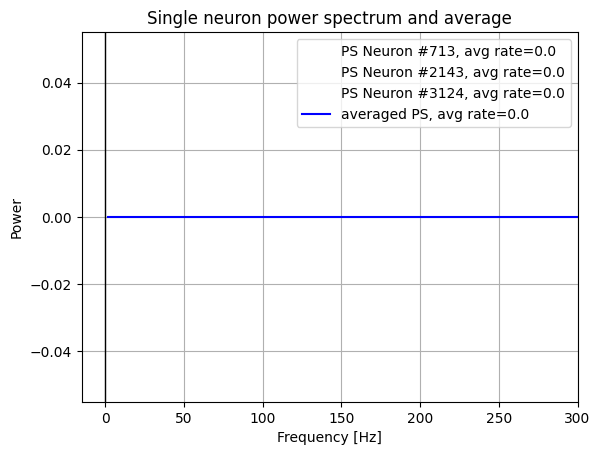

In [31]:
plot_tools.plot_network_activity(rate_E, spikes_E, t_min = 12500 *ms, spike_train_idx_list=list(range(4000)))
pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_E, delta_f, k, T_init)
plot_population_activity_power_spectrum(pop_freqs, pop_ps, 300 * Hz, average_population_rate)
freq, mean_ps, all_ps, mean_firing_rate, all_mean_firing_freqs = \
    get_averaged_single_neuron_power_spectrum(
        spikes_E, sampling_frequency=1./delta_t, window_t_min= T_init,
        window_t_max=T_sim, nr_neurons_average= 4000 )
plot_spike_train_power_spectrum(freq, mean_ps, all_ps, max_freq= 300 * Hz,
                                           mean_firing_freqs_per_neuron=all_mean_firing_freqs,
                                           nr_highlighted_neurons=3)

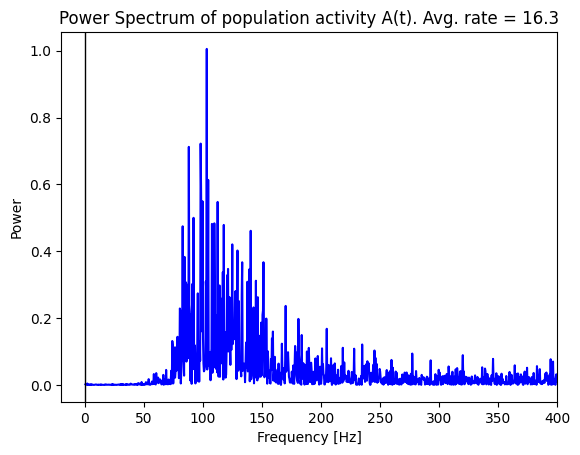

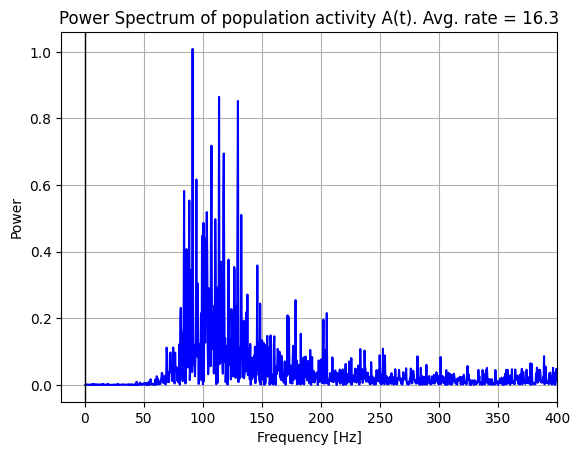

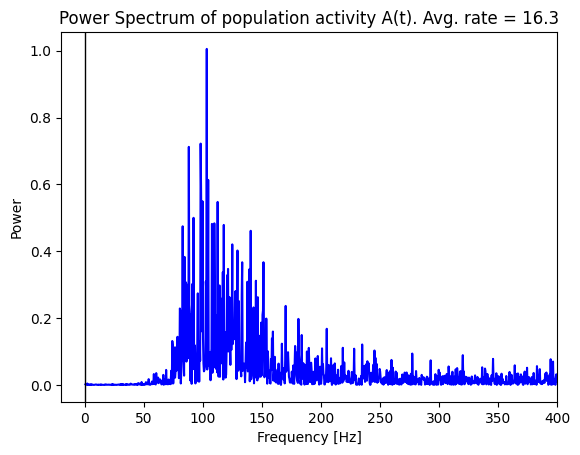

In [ ]:
pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_I, delta_f, k, T_init)
pop_freqs_after, pop_ps_after, average_population_rate_after = get_population_activity_power_spectrum(rate_I_after, delta_f, k, T_init)
plt.figure()
max_freq = 400 *Hz
plt.plot(pop_freqs[1:], pop_ps[1:], "b")
plt.plot(pop_freqs_after[1:], pop_ps_after[1:], "darkblue")
plt.axvline(x=0., lw=1, color="k")
plt.xlim([-.05*max_freq/b2.Hz, max_freq/b2.Hz])
plt.grid()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")

4000 2500.5
mean_firing_rate:0.0
1051
231
1531


(<Figure size 640x480 with 1 Axes>, [1051, 231, 1531])

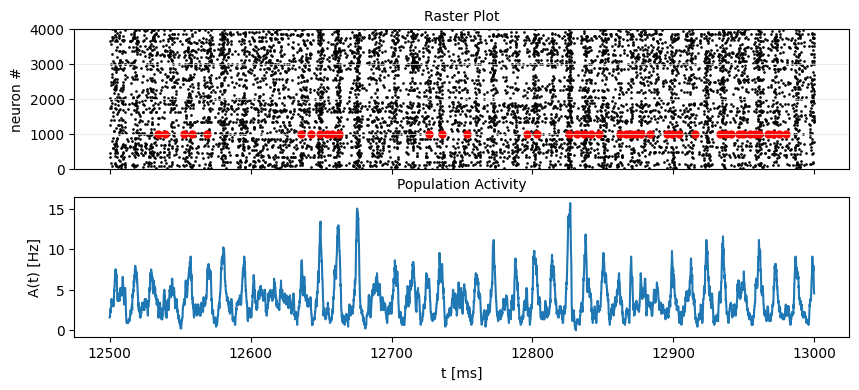

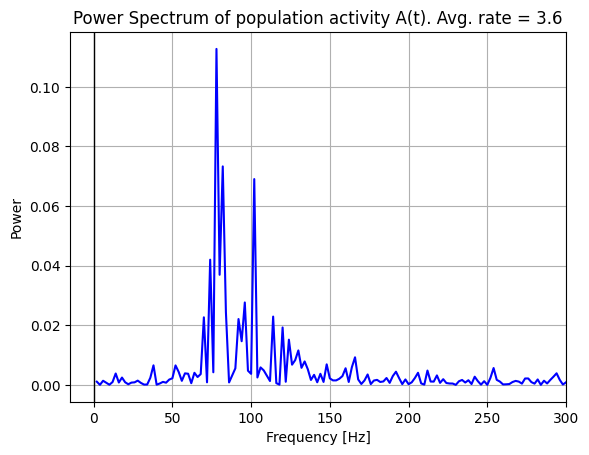

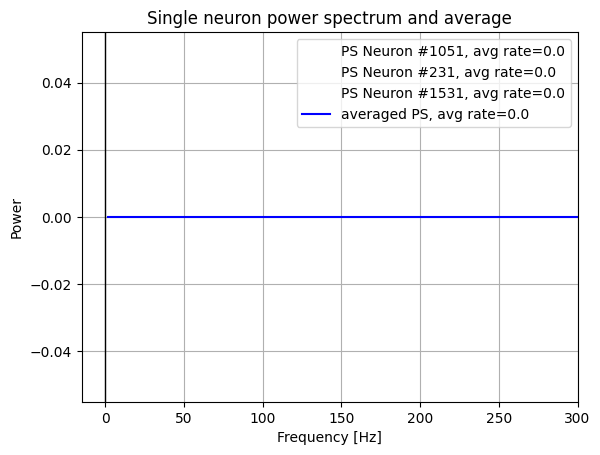

In [58]:
plot_tools.plot_network_activity(rate_E_after, spikes_E_after, t_min = 12500 *ms, spike_train_idx_list=list(range(4000)))
pop_freqs, pop_ps, average_population_rate = get_population_activity_power_spectrum(rate_E_after, delta_f, k, T_init)
plot_population_activity_power_spectrum(pop_freqs, pop_ps, 300 * Hz, average_population_rate)
freq, mean_ps, all_ps, mean_firing_rate, all_mean_firing_freqs = \
    get_averaged_single_neuron_power_spectrum(
        spikes_E_after, sampling_frequency=1./delta_t, window_t_min= T_init,
        window_t_max=T_sim, nr_neurons_average= 4000 )
plot_spike_train_power_spectrum(freq, mean_ps, all_ps, max_freq= 300 * Hz,
                                           mean_firing_freqs_per_neuron=all_mean_firing_freqs,
                                           nr_highlighted_neurons=3)